# (0) Download Butterfly 

# (1) Process Butterfly Data

In [1]:
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import trange
import numpy as np
import os
import random
import timm
device = 'cuda' 

In [2]:
# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label
    
# Create dataset from raw structure obtained from Kaggle
# (1): Download dataset fron Kaggle: https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species?select=train
# (2): Unzip the downloaded dataset to './data/butterfly'
# (3): Run the function
def create_dataset(path = './data/butterfly/'):
    transform = transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    train_path = path + 'train'
    test_path = path + 'test'
    
    class_names=sorted(os.listdir(train_path))
    N=list(range(len(class_names)))
    normal_mapping=dict(zip(class_names,N)) 
    reverse_mapping=dict(zip(N,class_names))

    paths0=[]
    for dirname, _, filenames in os.walk(train_path):
        for filename in filenames:
            if filename[-4:]=='.jpg':
                path=os.path.join(dirname, filename)
                label=dirname.split('\\')[-1]
                if label == '.ipynb_checkpoints':
                    continue
                paths0+=[(path,normal_mapping[label])]
            
    tpaths0=[]
    for dirname, _, filenames in os.walk(test_path):
        for filename in filenames:
            if filename[-4:]=='.jpg':
                path=os.path.join(dirname, filename)
                label=dirname.split('\\')[-1]
                if label == '.ipynb_checkpoints':
                    continue
                tpaths0+=[(path,normal_mapping[label])]

    random.shuffle(paths0)            
    random.shuffle(tpaths0)  

    
    trainset = ImageDataset(paths0, transform)
    testset = ImageDataset(tpaths0, transform)
    
    return trainset, testset, normal_mapping, reverse_mapping


trainset, testset, normal_mapping, reverse_mapping = create_dataset()
assert len(trainset) == 12594, 'Size of train set not match'
assert len(testset) == 500, 'Size of test set not match'

In [3]:
class DenseNet121(nn.Module):

    def __init__(self, num_classes, model='densenet121', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model, pretrained, in_chans=3)
        self.fc1 = nn.Linear(1000,32)
        self.fc2 = nn.Linear(32,64)        
        self.fc3 = nn.Linear(64,num_classes)

        
    def forward(self, x):
        x = self.model(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
model = DenseNet121(num_classes=len(normal_mapping))
model.load_state_dict(torch.load('butterfly_classifier.pth'))

<All keys matched successfully>

# NES

In [55]:
#Query limited attack using NES
def NES(model, target_class, image, search_var, sample_num, device, g, u_i):
    #parameters
    n = sample_num #should be even
    N = image.size(2) #assume the image is N x N may subject to change
    
    #NES estimation
    g.zero_()
    with torch.no_grad():
        for i in range(n):
            u_i.normal_()
            g = g + F.softmax(model(image + search_var * u_i), dim =1)[0,target_class] * u_i
            g = g - F.softmax(model(image - search_var * u_i), dim =1)[0,target_class] * u_i #we assume the output of the model is ordered by class index
    return 1 / (2*n*search_var) * g

def adversarial_generator(model, target_class, image, search_var, sample_num, bound, lr, query_limit, device):
    from tqdm import tqdm 
    image = image.to(device)
    adv_image = image.clone()
    adv_image = adv_image.to(device)
    N = image.size(2)
    g = torch.zeros(N, requires_grad=False).to(device)
    u_i = torch.randn((N,N)).to(device)
    with torch.no_grad():
        for i in tqdm(range(query_limit // sample_num)):
            gradient = NES(model, target_class, adv_image, search_var, sample_num, device, g, u_i)
            tmp = adv_image - lr * torch.sign(gradient)
            #projected gradient descent
            adv_image = torch.clamp(tmp, min=image-bound, max=image + bound)
            #adv_image = torch.max(torch.min(tmp, image + bound), image - bound)
    return adv_image

In [38]:
test_loader = DataLoader(dataset=testset, batch_size=100)
model.to(device)
model.eval()
count = 0
with torch.no_grad():
    for batch_idx, (inp, label) in enumerate(test_loader):
        inp, label = inp.to(device), label.to(device)
        output = model(inp)
        output = torch.argmax(output, dim=1)
        count += (output == label).sum()
count / 500

tensor(0.9480, device='cuda:0')

In [ ]:
model = model.to('cuda')
a = NES(model, 20, testset[0][0].unsqueeze(0), 1, 10, 'cuda')
a

In [88]:
fake = adversarial_generator(model, 40, testset[1][0].unsqueeze(0), 1e-3, 50, 0.3, 0.1, 5000, 'cuda')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:03<00:00,  2.43s/it]


In [79]:
fake

tensor([[[[1.6489, 1.6489, 1.6489,  ..., 2.6318, 2.8489, 2.8489],
          [1.4489, 2.4489, 2.6489,  ..., 1.5975, 2.4489, 2.4489],
          [2.4489, 1.4489, 1.6489,  ..., 1.4975, 3.2489, 3.0489],
          ...,
          [1.5489, 1.6489, 1.3489,  ..., 2.6489, 1.4489, 2.8489],
          [2.6489, 3.0489, 2.2489,  ..., 3.2489, 1.6489, 2.4489],
          [2.8489, 2.0489, 2.4489,  ..., 1.2489, 1.6489, 1.8489]],

         [[1.8286, 1.8286, 1.8286,  ..., 2.8286, 3.0111, 2.9760],
          [1.6286, 2.6286, 2.8286,  ..., 1.8286, 2.6286, 2.5936],
          [2.6286, 1.6286, 1.8286,  ..., 1.7286, 3.4286, 3.1936],
          ...,
          [1.7286, 1.8286, 1.5286,  ..., 2.8286, 1.6286, 3.0286],
          [2.8286, 3.2286, 2.4286,  ..., 3.4286, 1.8286, 2.6286],
          [3.0286, 2.2286, 2.6286,  ..., 1.4286, 1.8286, 2.0286]],

         [[2.0400, 2.0400, 2.0400,  ..., 3.0051, 3.1703, 3.1703],
          [1.8400, 2.8400, 3.0400,  ..., 2.0051, 2.8051, 2.7703],
          [2.8400, 1.8400, 2.0400,  ..., 1

In [89]:
print(torch.argmax(model(fake)))
print(torch.argmax(model(testset[1][0].unsqueeze(0).to(device))))
print(model(fake)[0,40])
print(model(fake)[0,97])
print(model(testset[1][0].unsqueeze(0).to(device))[0,40])
print(model(testset[1][0].unsqueeze(0).to(device))[0,97])

tensor(40, device='cuda:0')
tensor(40, device='cuda:0')
tensor(12.9400, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.1438, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(14.9477, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.1933, device='cuda:0', grad_fn=<SelectBackward0>)


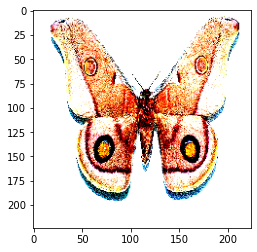

In [90]:
#plt.imshow(torch.transpose(testset[1][0],1,3))
def imshow(img):
    # unnormalize
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow(testset[1][0])
imshow(fake.detach().cpu().view(testset[0][0].size()))

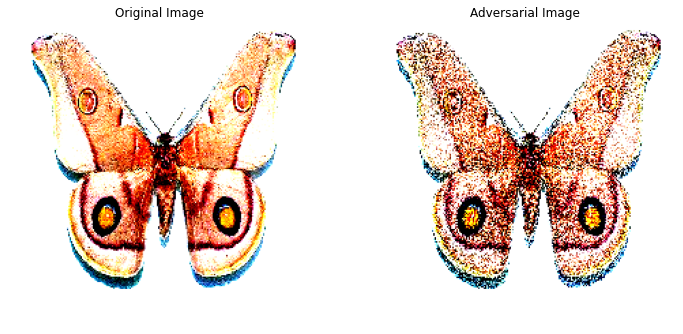

In [87]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
imshow(testset[1][0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
imshow(fake.detach().cpu().view(testset[0][0].size()))
plt.title('Adversarial Image')
plt.axis('off')

plt.show()

In [ ]:
torch.argmax(model(testset[0][0].unsqueeze(0).to(device)))
model.to('cpu')
adversarial_generator(model, 20, testset[0][0].unsqueeze(0), 1, 50, 1, 1, 1000)

In [ ]:
model(testset[0][0].unsqueeze(0))[0,20]

# Partial Information Attacker (PIA)

In [ ]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

def predict_top_classes(model, image, topk=1):
    """
    Function to get the top predicted classes from the model.
    Assumes the model outputs logits and you can get the topk classes.
    """
    with torch.no_grad():
        logits = model(image)
        topk_probs, topk_classes = torch.topk(logits, topk)
    return topk_classes.cpu().numpy()

def partial_information_attack(model, original_image, target_image, target_label, alpha=0.01, beta=0.005, iterations=100, topk=1):
    """
    Perform the Partial Information Attack.
    """
    adversarial_image = target_image.clone()

    for i in range(iterations):
        blended_image = (1 - alpha) * adversarial_image + alpha * original_image

        top_classes = predict_top_classes(model, blended_image, topk=topk)

        # Check if target label is in top classes
        if target_label in top_classes:
            # Increase original image content
            alpha = min(alpha + beta, 1)
        else:
            # Increase target image content
            alpha = max(alpha - beta, 0)

        adversarial_image = blended_image

    return adversarial_image

# Load the original and target images (same as before)
original_image, target_label = testset[0]  # Replace 0 with the index of your choice
target_class = reverse_mapping[target_label]  # Replace with your target class name
target_image, _ = next((img, lbl) for img, lbl in trainset if lbl == target_label)

# Add batch dimension and move to the same device as the model
original_image_batch = original_image.unsqueeze(0).to(device)
target_image_batch = target_image.unsqueeze(0).to(device)

# Run the Partial Information Attack
adversarial_image = partial_information_attack(model, original_image_batch, target_image_batch, target_label, alpha=0.01, beta=0.005, iterations=100, topk=1)

# Convert images back to PIL for visualization
transform_back = transforms.ToPILImage()

original_image_pil = transform_back(original_image)
adversarial_image_pil = transform_back(adversarial_image.squeeze(0).cpu())

# Display original and adversarial images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image_pil)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adversarial_image_pil)
plt.title('Adversarial Image')
plt.axis('off')

plt.show()

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor that has already been denormalized."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert from PyTorch to numpy format and rearrange color channels
    inp = np.clip(inp, 0, 1)  # Ensure values are within [0, 1] for proper display
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Assuming original_image and adversarial_image are your images

# Reverse normalization for visualization
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(tensor.device)
    tensor = tensor * std + mean  # reverse the normalization
    tensor = tensor.clamp(0, 1)   # clamp the values to be between 0 and 1
    return tensor

# Denormalize images
original_image_denorm = denormalize(original_image.squeeze(0))
adversarial_image_denorm = denormalize(adversarial_image.squeeze(0))

# Move tensors to the same device (e.g., CPU for imshow)
original_image_denorm = original_image_denorm.cpu()
adversarial_image_denorm = adversarial_image_denorm.cpu()

# Create a grid of images
image_grid = torchvision.utils.make_grid([original_image_denorm, adversarial_image_denorm])

# Show images
plt.figure(figsize=(10, 5))
imshow(image_grid, title=['Original Image', 'Adversarial Image'])

In [ ]:
target_class

## Query Limited

In [ ]:
#Query limited attack using NES
def NES(model, target_class, image, search_var, sample_num):
    #parameters
    n = sample_num #should be even
    N = image.size(0) #assume the image is n x N x N may subject to change

    #NES estimation
    g = torch.zeros(n)
    for i in range(n):
        u_i = torch.randn((N,N))
        g = g + model(image + search_var * u_i)[target_class] * u_i
        g = g - model(image - search_var * u_i)[target_class] * u_i #we assume the output of the model is ordered by class index
    return 1 / (2*n*search_var) * g

def adversarial_generator(model, target_class, image, search_var, sample_num, bound, lr, query_limit):
    adv_image = image.copy()
    for i in range(query_limit // sample_num):
        gradient = NES(model, target_class, adv_image, search_var, sample_num)
        tmp = adv_image - lr * torch.sign(gradient)
        #projected gradient descent
        adv_image = torch.max(torch.min(adv_image, image + bound), image - bound)
    return adv_image